In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

snowflow_data_fn = 'boise_river_snow2flow.csv'

In [12]:
snowflow_data_df = pd.read_csv(snowflow_data_fn, index_col='datetime', parse_dates=True)
snowflow_data_df

,prec_mm,tavg_degc,swe_mm,flow_cms
datetime,,,,
2000-10-01,5.08,5.0,0.00,8.693589
2000-10-02,0.00,2.6,0.00,9.061721
2000-10-03,0.00,0.9,0.00,8.806861
2000-10-04,0.00,1.7,0.00,8.778543
2000-10-05,0.00,-0.5,0.00,8.750225
...,...,...,...,...
2025-09-26,0.00,8.9,0.00,7.674145
2025-09-27,0.00,8.7,0.00,7.617510
2025-09-28,0.00,11.5,0.00,7.617510


In [85]:
mon_prec_sum = snowflow_data_df['prec_mm'].groupby([snowflow_data_df.index.year,snowflow_data_df.index.month]).sum().values
mon_temp_avg = snowflow_data_df['tavg_degc'].groupby([snowflow_data_df.index.year,snowflow_data_df.index.month]).mean().values
mon_temp_maxrat = snowflow_data_df['tavg_degc'].groupby([snowflow_data_df.index.year,snowflow_data_df.index.month]).max().values / mon_temp_avg
mon_temp_minrat = snowflow_data_df['tavg_degc'].groupby([snowflow_data_df.index.year,snowflow_data_df.index.month]).min().values / mon_temp_avg
mon_swe_max = snowflow_data_df['swe_mm'].groupby([snowflow_data_df.index.year,snowflow_data_df.index.month]).max().values
mon_swe_range = (snowflow_data_df['swe_mm'].groupby([snowflow_data_df.index.year,snowflow_data_df.index.month]).max() 
                 - snowflow_data_df['swe_mm'].groupby([snowflow_data_df.index.year,snowflow_data_df.index.month]).min()).values
mon_flow_avg = snowflow_data_df['flow_cms'].groupby([snowflow_data_df.index.year,snowflow_data_df.index.month]).mean().values
mon_flow_avg_ln = np.log(mon_flow_avg)

In [65]:
snowflow_data_months = snowflow_data_df.groupby([snowflow_data_df.index.year,snowflow_data_df.index.month]).first().index.get_level_values(1).values

mon_sin = np.sin(snowflow_data_months/12 * (2 * np.pi))
mon_cos = np.cos(snowflow_data_months/12 * (2 * np.pi))

In [88]:
X = np.column_stack((mon_sin, 
                     mon_cos, 
                     mon_prec_sum, 
                     mon_temp_avg,
                     mon_temp_maxrat,
                     mon_temp_minrat, 
                     mon_swe_max, 
                     mon_swe_range, 
                     mon_flow_avg_ln))
X = X[0:-1,:]
X.shape

(299, 9)

In [89]:
scaler = StandardScaler()

scaler.fit(X)

X_transformed = scaler.transform(X)

In [90]:
y = mon_flow_avg_ln[1:]
y.shape

(299,)

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

In [92]:
# 3. Create DMatrix objects for XGBoost
# DMatrix is an optimized data structure for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [121]:
# 4. Define XGBoost parameters
params = {
    'objective': 'reg:squarederror',  # Objective for regression (mean squared error)
    'eval_metric': 'rmse',            # Evaluation metric (Root Mean Squared Error)
    'max_depth': 7,                   # Maximum depth of a tree
    'eta': 0.02,                       # Learning rate (step size shrinkage)
    'subsample': 0.8,                 # Subsample ratio of the training instance
    'colsample_bytree': 0.8,          # Subsample ratio of columns when constructing each tree
    'seed': 42                        # Random seed for reproducibility
}

In [122]:
# 5. Train the XGBoost model
num_rounds = 500  # Number of boosting rounds (trees)
model = xgb.train(params, dtrain, num_rounds)

In [123]:
# 6. Make predictions on the test set
y_pred = model.predict(dtest)

# 7. Evaluate the model
mse = mean_squared_error(np.exp(y_test), np.exp(y_pred))
rmse = np.sqrt(mse)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")

Mean Squared Error: 86.4743
Root Mean Squared Error: 9.2992


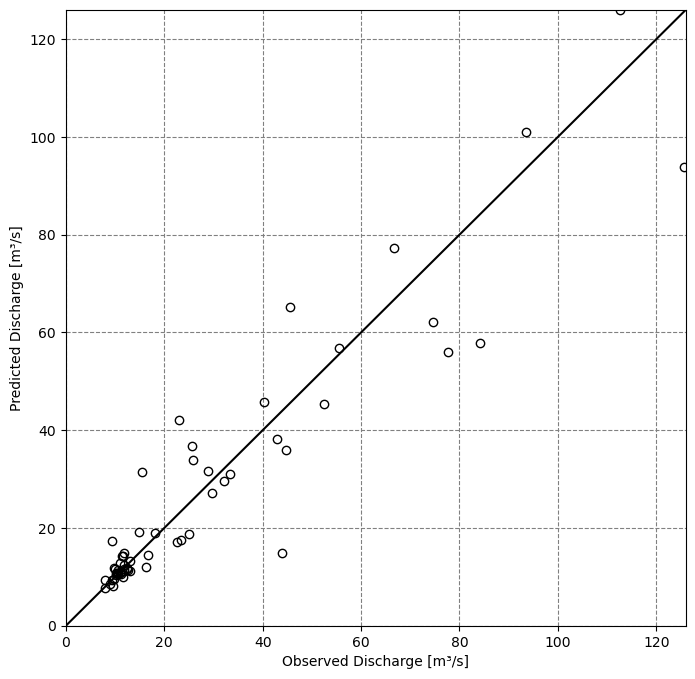

In [124]:
one2one = np.linspace(0,np.max((np.exp(y_pred).max(),np.exp(y_test).max())),100)

fig = plt.figure(figsize=(8,8))
plt.plot(np.exp(y_test),np.exp(y_pred), marker='o', markerfacecolor='None', markeredgecolor='k', linestyle='None')
plt.plot(one2one,one2one,'k-')
plt.xlim([0, one2one.max()])
plt.ylim([0, one2one.max()])
plt.grid('on',color='grey', linestyle='--')
plt.xlabel('Observed Discharge [m\u00b3/s]')
plt.ylabel('Predicted Discharge [m\u00b3/s]')
plt.show()